In [133]:
#data manipulation
import numpy as np
import pandas as pd
pd.option_context('display.max_rows', None, 'display.max_columns', None)
import nltk
from nltk.tokenize import word_tokenize

#stats/ml
import scipy
import sklearn as sk
from scipy.stats import ttest_1samp
from scipy.stats import boxcox
from scipy.stats import chisquare
from sklearn.preprocessing import OneHotEncoder

#vis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#additional support packages
from datetime import date, datetime, timedelta
import random
import re
import os
# nltk.download('punkt')
os.cpu_count()

12

In [2]:
def bin_small(col,replace_val,threshold=100,**kwargs):
    more_removal = [i for i,x in dict(data[col].value_counts()).items() if x<threshold]
    data[col]=np.where(data[col].isin(more_removal),replace_val,data[col])

<a id='top'></a>
# Overview

1. [Data Cleaning](#sec-1)
- Nulls
- Data inconsistencies
    
    
2. [Feature Engineering](#sec-2)
- 5 new features


3. [Additional Exploratory Data Analysis (EDA)](#sec-3)
- Univariate analysis of dependent variable
- Exploring independent variables relationships with each other and dependent variable

<a id='sec-1'></a>
## 1. Data Cleaning

In [3]:
data = pd.read_csv(r'..\data\adopt.csv')
data

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Time at Center
0,A745079,Transfer,Unknown,NaN,7920 Old Lockhart in Travis (TX),Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,Blue,3,0
1,A801765,Transfer,Intact Female,NaN,5006 Table Top in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,Brown Tabby/White,28,0
2,A667965,Transfer,Neutered Male,NaN,14100 Thermal Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,Chihuahua Shorthair Mix,Brown/Tan,1825,0
3,A687551,Transfer,Intact Male,NaN,5811 Cedardale Dr in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Brown Tabby,28,0
4,A773004,Adoption,Neutered Male,*Boris,Highway 290 And Arterial A in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,Tricolor/Cream,365,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95379,A706720,Adoption,Neutered Male,Nikko,Mc Callen Pass And Parmer in Austin (TX),Stray,Normal,Dog,Neutered Male,Miniature Schnauzer Mix,Tan/Gray,1460,0
95380,A782751,Adoption,Neutered Male,NaN,18706 Blake Manor Rd in Manor (TX),Stray,Normal,Dog,Intact Male,American Pit Bull Terrier Mix,Brown,60,0
95381,A768058,Euthanasia,Unknown,NaN,1701 Congress Avenue in Austin (TX),Wildlife,Normal,Other,Unknown,Bat Mix,Black/Black,730,0
95382,A729326,Adoption,Neutered Male,*Jester,5017 W. 290 in Austin (TX),Stray,Normal,Dog,Intact Male,Pointer Mix,Black/White,730,0


In [4]:
data['Outcome Type'].value_counts()

Adoption           39734
Transfer           32299
Return to Owner    13719
Euthanasia          7630
Died                1053
Disposal             503
Rto-Adopt            369
Missing               52
Relocate              20
Name: Outcome Type, dtype: int64

In [5]:
data['Time at Center'].value_counts()[1]/data['Time at Center'].value_counts()[0]

0.09577584523303502

In [6]:
data['Time at Center'].value_counts()

0    87047
1     8337
Name: Time at Center, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95384 entries, 0 to 95383
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Pet ID                95384 non-null  object
 1   Outcome Type          95379 non-null  object
 2   Sex upon Outcome      95383 non-null  object
 3   Name                  59093 non-null  object
 4   Found Location        95384 non-null  object
 5   Intake Type           95384 non-null  object
 6   Intake Condition      95384 non-null  object
 7   Pet Type              95384 non-null  object
 8   Sex upon Intake       95383 non-null  object
 9   Breed                 95384 non-null  object
 10  Color                 95384 non-null  object
 11  Age upon Intake Days  95384 non-null  int64 
 12  Time at Center        95384 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 9.5+ MB


### KEY POINTS IDENTIFIED:
    
1. **Primary key - "Pet ID" column**
    - We will check for uniqueness later


1. **4 columns with inconsistent non-null counts**
    - Name - 59093 count
    - Outcome - 95379 count
    - Sex upon Outcome - 95383 count
    - Sex upon Intake - 95383 count
    
    
3. **One integer, independent variable**
    - Age (days), discrete values 
    
    
4. **10 objects, independent variables**
    - Categorical
    - *Note: "Name" weak as categorical. Given the high nulls and high uniqueness of names, it is likely we may have to drop name as a feature, will explore further*
    
    
5. **Dependent variable: "Time at Center"**

In [8]:
data.describe()

,Age upon Intake Days,Time at Center
count,95384.000000,95384.000000
mean,704.154691,0.087405
std,1052.579518,0.282429
min,0.000000,0.000000
25%,30.000000,0.000000
50%,365.000000,0.000000
75%,730.000000,0.000000
max,9125.000000,1.000000


"Time at Center" can be ignored because it is a boolean masked as an integer column. 

"Age upon Intake Days" the standard deviation is larger than the mean value. This suggests there are some large outliers on the upper bound. We will investigate what steps need to be taken for this column in the section 3 of this notebook

### Checking Primary Key column

In [9]:
data['Pet ID'].value_counts().max()

1

"Pet ID" column is indeed unique. Let's make sure all columns contain the same data type

### Checking for mixed data type columns

In [10]:
for i in data.columns.values:
    type_array = data[i].apply(type).value_counts()
    if len(type_array)>1:
        print(f'{type_array}')
        print()
    else:
        pass

<class 'str'>      95379
<class 'float'>        5
Name: Outcome Type, dtype: int64

<class 'str'>      95383
<class 'float'>        1
Name: Sex upon Outcome, dtype: int64

<class 'str'>      59093
<class 'float'>    36291
Name: Name, dtype: int64

<class 'str'>      95383
<class 'float'>        1
Name: Sex upon Intake, dtype: int64



All columns listed above are columns with null values based on the info method we passed earlier. The additional floating point values are nulls. We're going to take a look at "Outcome Type", "Sex upon Outcome" and "Sex upon Intake" first because the number of null values is low. We should easily be able to determine what to do with these null values. Then we will take a look at "Name"

### Handling "Outcome Type" nulls

In [11]:
data['Outcome Type'].value_counts()

Adoption           39734
Transfer           32299
Return to Owner    13719
Euthanasia          7630
Died                1053
Disposal             503
Rto-Adopt            369
Missing               52
Relocate              20
Name: Outcome Type, dtype: int64

In [12]:
data.loc[data['Outcome Type'].isnull()]

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Time at Center
828,A674209,NaN,Unknown,NaN,4210 W. Braker in Austin (TX),Wildlife,Normal,Other,Unknown,Bat Mix,Brown,0,0
10178,A679066,NaN,Unknown,NaN,Austin (TX),Wildlife,Normal,Other,Unknown,Rabbit Sh,Brown,28,0
18664,A686025,NaN,Unknown,NaN,12901 N Ih 35 #1100 in Austin (TX),Wildlife,Normal,Other,Unknown,Bat Mix,Brown,365,0
47605,A671017,NaN,Unknown,NaN,10105 Falcon Ridge Dr. in Travis (TX),Wildlife,Sick,Other,Unknown,Fox Mix,Brown/Black,365,0
58378,A815725,NaN,Unknown,NaN,321 West Ben White in Austin (TX),Wildlife,Normal,Other,Unknown,Bat,Black,365,0


Based on the values in "Outcome Type" and the number of nulls is low (5), I don't think imputing the values or replacing it with a dummy category like "blank" is necessary and we can likely remove these values. We just need to check these nulls are not associated with rare information in other columns.

Check
- Unknown in "Sex upon Outcome" and "Sex upon Intake" is not associated only with null outcome type
- "Name" has many nulls so we do not have to check
- "Found Location", perhaps City, Province will need to be extracted and checked
- "Intake Type" ensure Wildlife is not associated only with null outcome type
- "Pet Type" ensure Other is not associated with only null outcome type
- "Breed" seems mixed, double check bat info is not under-represented after removal
- "Age upon Intake Days" ensure distribution is not affected from removal of 0,28,365,365,365
- "Time at Center" ensure dependent variable not largely affected by removal

In [13]:
for i in ['Sex upon Outcome','Intake Type','Intake Condition','Sex upon Intake','Pet Type']:
    print(data[i].value_counts())
    print()

Neutered Male    30233
Spayed Female    28123
Intact Female    13686
Intact Male      13614
Unknown           9727
Name: Sex upon Outcome, dtype: int64

Stray                 70112
Owner Surrender       15131
Public Assist          5236
Wildlife               4559
Euthanasia Request      235
Abandoned               111
Name: Intake Type, dtype: int64

Normal      81824
Injured      5384
Sick         4289
Nursing      3163
Aged          352
Other         189
Feral          97
Pregnant       63
Medical        21
Behavior        2
Name: Intake Condition, dtype: int64

Intact Male      33326
Intact Female    32455
Neutered Male    10521
Unknown           9727
Spayed Female     9354
Name: Sex upon Intake, dtype: int64

Dog          48674
Cat          40023
Other         6118
Bird           553
Livestock       16
Name: Pet Type, dtype: int64



In [14]:
data.loc[data.Breed.str.contains('Bat')].shape[0]

3030

Based on these values, removal of the 5 nulls from "Outcome Type" will not impact the dataset. Now to look at "Sex upon Outcome".

In [15]:
data=data.loc[data['Outcome Type'].notnull()] #removing nulls from Outcome Type

### Handling "Sex upon Outcome" and "Sex upon Intake" fields

In [16]:
data.loc[data['Sex upon Outcome'].isnull()] 

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Time at Center
38480,A667395,Return to Owner,NaN,Diego,Pflugerville (TX),Owner Surrender,Normal,Dog,NaN,Dachshund,Brown Merle,2555,0


Based on analysis of previous columns, we can include this record by replacing the null values with "Unknown" in both gender related columns. Unknown is already used to fill missing values in these columns.

In [17]:
data['Sex upon Outcome'].fillna('Unknown',inplace=True)
data['Sex upon Intake'].fillna('Unknown',inplace=True)

<ipython-input-17-5cfb2159ccd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sex upon Outcome'].fillna('Unknown',inplace=True)
<ipython-input-17-5cfb2159ccd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sex upon Intake'].fillna('Unknown',inplace=True)


## Dealing with Name

Because almost 40% of the data has null name values, we will not be removing them. Instead, we will replace the values with "Unknown" to stay consistent with other column nomenclature for null values.


In [18]:
data['Name'].fillna('Unknown',inplace=True)

<ipython-input-18-3faac54ba18c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Name'].fillna('Unknown',inplace=True)


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95379 entries, 0 to 95383
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Pet ID                95379 non-null  object
 1   Outcome Type          95379 non-null  object
 2   Sex upon Outcome      95379 non-null  object
 3   Name                  95379 non-null  object
 4   Found Location        95379 non-null  object
 5   Intake Type           95379 non-null  object
 6   Intake Condition      95379 non-null  object
 7   Pet Type              95379 non-null  object
 8   Sex upon Intake       95379 non-null  object
 9   Breed                 95379 non-null  object
 10  Color                 95379 non-null  object
 11  Age upon Intake Days  95379 non-null  int64 
 12  Time at Center        95379 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 10.2+ MB


Now all columns in our data set have the same number of non-null values. We have removed 5 rows from the entire dataset from this cleaning step

## Ensuring data consistencies
- Noticed "*" prefix to certain names - need to clean this up
- Check other columns for formatting inconsistencies

### "Name" cleaning

In [20]:
len(data.Name.unique())

17464

In [21]:
data['Name']=data['Name'].str.replace('[*]','',regex=True) #remove asteriks
print(len(data.Name.unique()))
data.Name.value_counts()

14107


<ipython-input-21-719e600a3ca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Name']=data['Name'].str.replace('[*]','',regex=True) #remove asteriks


Unknown       36304
Bella           370
Max             359
Luna            344
Charlie         305
              ...  
Fritzi            1
Kit-Teacup        1
Shuggie           1
Amaretto          1
Superman          1
Name: Name, Length: 14107, dtype: int64

Reduced unique values by 2,700. We will skip looking at "Sex upon Outcome", "Intake Type","Intake Condition","Pet Type","Sex upon Intake" because we have seen their values before and they look fine.

We'll now look at "Found Location" column. 

Then "Breed" and "Color".

### "Found Location" check

In [22]:
data['Found Location'].value_counts()

Austin (TX)                                     14821
Travis (TX)                                      1400
7201 Levander Loop in Austin (TX)                 637
Outside Jurisdiction                              605
Del Valle (TX)                                    426
                                                ...  
11711 Maybock Dr in Travis (TX)                     1
Copperfield Drive And Markham in Austin (TX)        1
15017 Babbling Brook Dr in Austin (TX)              1
1413 W William Cannon in Austin (TX)                1
5017 W. 290 in Austin (TX)                          1
Name: Found Location, Length: 43936, dtype: int64

Based on these values, it seems this column follows a consistent pattern. With 43936 unique values, it will not be a reliable categorical feature unless we can bin together some of these values and create more useful features.

(Street information (Optional)) (City) ((State))

We will look into it a bit further once we decompose it into useful features in the engineering section - City and State. 

### Breed check

In [23]:
data['Breed'].value_counts()

Domestic Shorthair Mix                27654
Domestic Shorthair                     5068
Pit Bull Mix                           5013
Chihuahua Shorthair Mix                4960
Labrador Retriever Mix                 4783
                                      ...  
Australian Shepherd/English Setter        1
Pointer/Queensland Heeler                 1
Brittany/Cocker Spaniel                   1
Cocker Spaniel/Golden Retriever           1
Redbone Hound/Boxer                       1
Name: Breed, Length: 2395, dtype: int64

2395 unique values is still quite high. The common values are types of mixes and the less common values are also mixes, but in different formats and more detailed.

We can consider strategies to simplify the detailed values that are generating unnecessarily unique values. Additionally we can decompose the "Breed" column into "Breed", which only contains the main breed listed, and "Mix" to define whether the "Breed" is purebred or mixed.

We will also need to look at this at by pet type. Different pet types may have different breed formatting.

In [24]:
data['Pet Type'].value_counts()

Dog          48674
Cat          40023
Other         6113
Bird           553
Livestock       16
Name: Pet Type, dtype: int64

Because the categorical size of  "Livestock" are is small, we will bin it together with "Other". The model will not be able to generalize correctly from such a small bin. "Bird" may be a bit small, but it may be relevant.

In [25]:
data['Pet Type']=data['Pet Type'].replace(to_replace={'Livestock':'Other'})

<ipython-input-25-09d109471959>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pet Type']=data['Pet Type'].replace(to_replace={'Livestock':'Other'})


In [26]:
data.loc[data['Pet Type']=='Other'].Breed.value_counts()

Bat Mix                 1740
Bat                     1287
Raccoon Mix              537
Raccoon                  364
Rabbit Sh Mix            322
                        ... 
Dutch/Rabbit Sh            1
Hotot                      1
Rabbit Sh/Lop-Mini         1
Rhinelander Mix            1
Rex-Mini/Lop-English       1
Name: Breed, Length: 125, dtype: int64

In [27]:
data.loc[data['Pet Type']=='Bird'].Breed.value_counts()

Chicken Mix     151
Chicken          77
Parakeet Mix     33
Parakeet         25
Duck Mix         21
               ... 
Vulture           1
Lark Mix          1
Waxwing Mix       1
Bunting           1
Goose Mix         1
Name: Breed, Length: 75, dtype: int64

In [28]:
data.loc[data['Pet Type']=='Cat'].Breed.value_counts()

Domestic Shorthair Mix                      27654
Domestic Shorthair                           5068
Domestic Medium Hair Mix                     2784
Domestic Longhair Mix                        1359
Siamese Mix                                  1132
                                            ...  
Japanese Bobtail/American Curl Shorthair        1
American Curl Shorthair/Siamese                 1
Manx/Domestic Medium Hair                       1
Siamese/Japanese Bobtail                        1
Tonkinese                                       1
Name: Breed, Length: 95, dtype: int64

In [29]:
data.loc[data['Pet Type']=='Dog'].Breed.value_counts()

Pit Bull Mix                       5013
Chihuahua Shorthair Mix            4960
Labrador Retriever Mix             4783
German Shepherd Mix                2043
Australian Cattle Dog Mix          1071
                                   ... 
Jack Russell Terrier/Papillon         1
Plott Hound/Whippet                   1
Pekingese/Lhasa Apso                  1
Alaskan Malamute/Siberian Husky       1
Redbone Hound/Boxer                   1
Name: Breed, Length: 2101, dtype: int64

After looking at all the different types of animals and their breeds my strategy to improve categorization from these columns is to identify whether a "Breed" value contains "Mix" or "/" and label them as "Mix" in the "Mix" column and as "Not" if otherwise.

We will then extract the string before "Mix" and "/" to re-categorize pure, mix and "mix detailed" formats together.

If that does not solve the complexity of the categorical column, we could use a more complex strategy of identifying the most common pure breed listed instead of the first. This is likely an unnecessary step so I will stick with a more simple strategy and move on.

In [30]:
data['Mix']=np.where((data['Breed'].str.contains('Mix'))|(data['Breed'].str.contains('/')),"Mix","Not")

data['Breed_new']=np.where(data['Breed'].str.contains('Mix'),data['Breed'].str.split('Mix').str[0],
                          np.where(data['Breed'].str.contains('/'),data['Breed'].str.split('/').str[0],data['Breed']))
print(len(data['Breed_new'].unique()))
data['Breed_new']=data['Breed_new'].str.lower()
print(len(data['Breed_new'].unique()))
data['Breed_new']=data['Breed_new'].str.strip()
print(len(data['Breed_new'].unique()))

<ipython-input-30-7c1a223b82dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mix']=np.where((data['Breed'].str.contains('Mix'))|(data['Breed'].str.contains('/')),"Mix","Not")


637
637
362


<ipython-input-30-7c1a223b82dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_new']=np.where(data['Breed'].str.contains('Mix'),data['Breed'].str.split('Mix').str[0],
<ipython-input-30-7c1a223b82dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_new']=data['Breed_new'].str.lower()
<ipython-input-30-7c1a223b82dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Reduced unique values from 2395 to 362. Let's see if there's any further reduction necessary. Categories with only 1-2 values are not good for model generalization on future data

In [31]:
breed=data['Breed_new'].value_counts().to_frame()
breed.describe()

,Breed_new
count,362.000000
mean,263.477901
std,1840.323954
min,1.000000
25%,4.000000
50%,13.000000
75%,69.750000
max,32734.000000


Huge difference between percentiles, mean and max values. More cleanup is required.

In [32]:
breed.sort_values(by='Breed_new',ascending=False).head(20).Breed_new.sum()

74787

In [33]:
breed.loc[breed.Breed_new<5]

,Breed_new
norwegian forest cat,4
port water dog,4
pixiebob shorthair,4
vulture,4
cockatoo,4
...,...
ocicat,1
dwarf hotot,1
eng toy spaniel,1
nuthatch,1


In [34]:
data['Pet Type'].value_counts()

Dog      48674
Cat      40023
Other     6129
Bird       553
Name: Pet Type, dtype: int64

I was stumped on the best way to reduce the number of bins in this category and just thought of using tokenization to reduce binning further. Other approaches I considered.

- Thresholding by mean or percentile values
    - *Issue: Even binning all categories under 600 in size led to 20k records with undefined breeds - a significant loss of information*
- Thresholding by a proportion of the minority class
    - e.g. Bins must contain 20% of minority class size
- Extract bi-grams to derive smaller groups
- Using Levenshtein distance to organize categories by edit distance
    
    
First we will bin the breeds of smaller "Pet Type" categories like "Bird" and "Other".


In [35]:
for i in data["Pet Type"].unique():
    breed_count = data.loc[data["Pet Type"]==i].Breed_new.value_counts().shape[0]
    print(f'Pet Type: {i}  |  Unique Breeds: {breed_count}')


Pet Type: Cat  |  Unique Breeds: 41
Pet Type: Dog  |  Unique Breeds: 202
Pet Type: Other  |  Unique Breeds: 72
Pet Type: Bird  |  Unique Breeds: 49


In [36]:
data.loc[data["Pet Type"]=='Bird'].Breed_new.value_counts()

chicken         228
parakeet         58
duck             37
dove             28
pigeon           23
cockatiel        18
grackle          15
parrot           11
sparrow          10
bantam            9
peafowl           9
quaker            8
hawk              8
finch             6
owl               6
rhode island      6
conure            5
lovebird          5
heron             5
mockingbird       5
turkey            5
vulture           4
muscovy           4
bluebird          4
cockatoo          4
guinea            3
budgerigar        3
macaw             2
black             2
barred rock       2
crow              2
african           1
orpington         1
canary            1
song bird         1
catbird           1
whimbrel          1
pheasant          1
chickadee         1
wren              1
silkie            1
lark              1
leghorn           1
bunting           1
waxwing           1
other bird        1
warbler           1
nuthatch          1
goose             1
Name: Breed_new, dty

In [37]:
data['Breed_new']=np.where((data['Pet Type']=='Bird')&(data['Breed_new']!='chicken'),'Other Bird',data['Breed_new'])
print(len(data.Breed_new.unique()))

316


<ipython-input-37-6f207744de77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_new']=np.where((data['Pet Type']=='Bird')&(data['Breed_new']!='chicken'),'Other Bird',data['Breed_new'])


In [38]:
for i,x in data.loc[data["Pet Type"]=='Other'].Breed_new.value_counts().iteritems():
    print(f'{i}                {x}')


bat                3027
raccoon                901
rabbit sh                406
guinea pig                335
opossum                320
skunk                178
squirrel                134
rat                109
fox                102
ferret                58
hamster                56
californian                55
snake                34
cold water                30
turtle                29
coyote                25
lionhead                25
rex                22
rabbit lh                17
lop-holland                16
english spot                16
lizard                16
tortoise                14
havana                13
new zealand wht                13
lop-mini                11
lop-english                11
american                10
mouse                10
pig                10
armadillo                10
netherlnd dwarf                9
dutch                9
chinchilla                8
gerbil                7
tarantula                6
rex-mini                5
cinnamon    

We will bin everything under 100 count. We could extract rodents to be in a category, as there is enough to make a bin larger than 300. However I don't think its going to affect performance too much.

In [39]:
remove_other = []
for i,x in data.loc[data["Pet Type"]=='Other'].Breed_new.value_counts().iteritems():
    if x<100:
        remove_other.append(i)
    else:
        pass
data['Breed_new']=np.where((data['Pet Type']=='Other')&(data['Breed_new'].isin(remove_other)),'Other',data['Breed_new'])
print(len(data.Breed_new.unique()))

255


<ipython-input-39-615d4d8f5899>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_new']=np.where((data['Pet Type']=='Other')&(data['Breed_new'].isin(remove_other)),'Other',data['Breed_new'])


In [40]:
data.loc[data["Pet Type"]=='Cat'].Breed_new.value_counts()

domestic shorthair         32734
domestic medium hair        3392
domestic longhair           1542
siamese                     1317
american shorthair           240
snowshoe                     181
maine coon                   127
manx                         108
russian blue                  79
ragdoll                       50
himalayan                     44
persian                       28
balinese                      17
bengal                        15
abyssinian                    14
angora                        13
american curl shorthair       13
tonkinese                     12
japanese bobtail               9
turkish van                    8
british shorthair              8
bombay                         7
devon rex                      7
turkish angora                 7
burmese                        6
cornish rex                    5
cymric                         4
pixiebob shorthair             4
norwegian forest cat           4
exotic shorthair               3
oriental s

Just gonna bin anything under 1000.

In [41]:
remove_other = []
for i,x in data.loc[data["Pet Type"]=='Cat'].Breed_new.value_counts().iteritems():
    if x<1000:
        remove_other.append(i)
    else:
        pass
data['Breed_new']=np.where((data['Pet Type']=='Cat')&(data['Breed_new'].isin(remove_other)),'Other Cat',data['Breed_new'])
print(len(data.Breed_new.unique()))

219


<ipython-input-41-253d1cb1b992>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_new']=np.where((data['Pet Type']=='Cat')&(data['Breed_new'].isin(remove_other)),'Other Cat',data['Breed_new'])


In [42]:
for i,x in data.loc[data["Pet Type"]=='Dog'].Breed_new.value_counts().iteritems():
    print(f'{i}                {x}')

labrador retriever                6818
chihuahua shorthair                6411
pit bull                6174
german shepherd                3043
australian cattle dog                1576
dachshund                1416
border collie                982
boxer                933
miniature poodle                908
yorkshire terrier                786
siberian husky                734
australian shepherd                719
beagle                695
great pyrenees                679
miniature schnauzer                655
catahoula                644
rat terrier                637
jack russell terrier                634
shih tzu                593
cairn terrier                570
chihuahua longhair                566
pointer                502
rottweiler                492
anatol shepherd                425
staffordshire                421
plott hound                361
maltese                350
american bulldog                327
pug                309
golden retriever                307
blac

In [43]:
#token approach
breed_dict={}
for i in data.loc[data['Pet Type']=='Dog']['Breed_new'].values:
    salad = word_tokenize(i)
    for s in salad:
        if s in breed_dict.keys():
            breed_dict[s]=breed_dict[s]+1
        else:
            breed_dict[s]=1
breed_list=[[i,x] for i,x in breed_dict.items()]
test=pd.DataFrame(data=breed_list,columns=['Token','Count'])
test.sort_values(by='Count',ascending=False).head(40)

,Token,Count
7,retriever,7228
0,chihuahua,6977
6,labrador,6818
11,bull,6524
1,shorthair,6481
10,pit,6418
9,terrier,4392
5,shepherd,4239
25,german,3131
48,australian,2607


In [44]:
d = data.loc[data.Breed_new.str.contains('retriever')].Breed_new.value_counts().iteritems()
next(d)
for i in d:
    print(i)

('golden retriever', 307)
('flat coat retriever', 91)
('nova scotia duck tolling retriever', 12)


In [45]:
replace_dict = {}
for i in test.iterrows():
    if i[1].Count>300:
        val_count = data.loc[(data.Breed_new.str.contains(i[1].Token))&(data['Pet Type']=='Dog')].Breed_new.value_counts()
        if len(val_count)>1:
            iter_obj = val_count.iteritems()
            next(iter_obj)
            for x in iter_obj:
                if x[0] not in replace_dict.keys(): #prevent multiple assignment
                    replace_dict[x[0]]=f'Other {i[1].Token}'
                else:
                    pass
    else:
        val_count = data.loc[(data.Breed_new.str.contains(i[1].Token))&(data['Pet Type']=='Dog')].Breed_new.value_counts()
        iter_obj = val_count.iteritems()
        for x in iter_obj:
            if x[0] not in replace_dict.keys(): #prevent multiple assignment
                replace_dict[x[0]]=f'Other dog'
            else:
                pass
data['Breed_test']=data.Breed_new.replace(to_replace=replace_dict)
# more_removal = [i for i,x in dict(data['Breed_test'].value_counts()).items() if x<300]
# data['Breed_test']=np.where(data['Breed_test'].isin(more_removal),'Other dog',data['Breed_test'])
# data['Breed_test'].value_counts()

<ipython-input-45-252e1e7a9a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Breed_test']=data.Breed_new.replace(to_replace=replace_dict)


In [46]:
len(data['Breed_test'].unique())

56

Reduced "Breed" to 47 unique values. We could have reduced it further, but I feel I've done enough.

Let's look at "Color" now

In [47]:
color=data['Color'].value_counts().to_frame()
color.describe()

,Color
count,567.000000
mean,168.216931
std,742.887193
min,1.000000
25%,1.000000
50%,3.000000
75%,25.000000
max,9671.000000


Another category with too many bins and too high a varianace

In [48]:
color.index.values

array(['Black/White', 'Black', 'Brown Tabby', 'Brown', 'White',
       'Brown Tabby/White', 'Orange Tabby', 'Brown/White', 'Tan/White',
       'White/Black', 'Blue/White', 'Tan', 'Tricolor', 'Black/Tan',
       'Black/Brown', 'Tortie', 'Calico', 'Blue', 'Brown/Black',
       'White/Brown', 'Blue Tabby', 'Orange Tabby/White', 'White/Tan',
       'Brown Brindle/White', 'Red', 'Torbie', 'Red/White',
       'Brown Brindle', 'Tan/Black', 'Blue Tabby/White', 'Cream Tabby',
       'Gray', 'Chocolate/White', 'Cream', 'Lynx Point', 'Yellow',
       'Gray/White', 'Seal Point', 'Black/Gray', 'Sable', 'White/Blue',
       'White/Brown Tabby', 'Gray/Black', 'Buff', 'Chocolate',
       'White/Gray', 'Cream Tabby/White', 'Black/Tricolor', 'Brown/Tan',
       'White/Brown Brindle', 'Fawn/White', 'Gray Tabby', 'Torbie/White',
       'Flame Point', 'Sable/White', 'Black Tabby', 'Blue Merle',
       'White/Tricolor', 'Fawn', 'Red/Black', 'Chocolate/Tan',
       'Cream/White', 'White/Red', 'Black Brindle/

1. Split mix colors out
2. Identify base color based on first one listed
3. Reduce base categories with too little data points into "Other color"


In [49]:
data['MixColor']=np.where(data.Color.str.contains('/'),'Mix','No Mix')
data['Color_new']=np.where(data.Color.str.contains('/'),data['Color'].str.split('/').str[0],data['Color'])
data.Color_new=data['Color_new'].str.split(' ').str[0]
more_removal = [i for i,x in dict(data['Color_new'].value_counts()).items() if x<100]
data['BaseColor']=np.where(data['Color_new'].isin(more_removal),'Other color',data['Color_new'])
data['BaseColor'].value_counts()

<ipython-input-49-55c6c4517429>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MixColor']=np.where(data.Color.str.contains('/'),'Mix','No Mix')
<ipython-input-49-55c6c4517429>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Color_new']=np.where(data.Color.str.contains('/'),data['Color'].str.split('/').str[0],data['Color'])
<ipython-input-49-55c6c4517429>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Black          24123
Brown          21109
White          11617
Blue            7211
Tan             5957
Orange          4690
Red             2682
Tricolor        2300
Gray            2172
Tortie          2133
Calico          1982
Cream           1919
Torbie          1444
Chocolate       1308
Sable            748
Yellow           706
Lynx             610
Fawn             561
Buff             540
Seal             493
Flame            253
Silver           242
Other color      238
Gold             208
Lilac            133
Name: BaseColor, dtype: int64

In [50]:
data['Intake Condition']=data['Intake Condition'].replace(to_replace={'Behavior':'Other','Medical':'Injured'})

<ipython-input-50-cf7cf1225bbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Intake Condition']=data['Intake Condition'].replace(to_replace={'Behavior':'Other','Medical':'Injured'})


Color reduced to 25 bins. Split into two features - mix color and base color. 

Next steps:
- Clean out deprecated columns
- Engage in additional feature engineering

In [51]:
data.rename(columns={'Mix':'MixBreed','Breed_test':'BaseBreed'},inplace=True) #standardize naming of columns
data=data[['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name',
       'Found Location', 'Intake Type', 'Intake Condition', 'Pet Type',
       'Sex upon Intake', 'Age upon Intake Days',
       'Time at Center', 'MixBreed', 'BaseBreed','MixColor', 'BaseColor']]


<ipython-input-51-080b28dc19c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Mix':'MixBreed','Breed_test':'BaseBreed'},inplace=True) #standardize naming of columns


<a id='sec-2'></a>
## 2. Feature Engineering

Ideas:
- Spay/Neuter status
- Spay/Neuter change status (at shelter)
- Location by City/State
- Name starting letter
- Name length


[*Back to top*](#top)

In [53]:
data['NS_intake']=np.where((data['Sex upon Intake'].str.contains('Neutered'))
                          |(data['Sex upon Intake'].str.contains('Spayed')), 1,0) #create boolean infertility on intake
data['Gender']=data['Sex upon Intake'].str.split(' ').str[-1] #new feature

print(data.NS_intake.value_counts())
print(data.Gender.value_counts())

0    75504
1    19875
Name: NS_intake, dtype: int64
Male       43847
Female     41809
Unknown     9723
Name: Gender, dtype: int64


In [54]:
data['Sex upon Outcome'].value_counts()

Neutered Male    30233
Spayed Female    28123
Intact Female    13686
Intact Male      13614
Unknown           9723
Name: Sex upon Outcome, dtype: int64

In [55]:
data['NS_clinic']=np.where((data.NS_intake==0)&((data['Sex upon Outcome'].str.contains('Neutered'))
                          |(data['Sex upon Outcome'].str.contains('Spayed'))),1,0) #new feature
data['NS_clinic'].value_counts()

0    56898
1    38481
Name: NS_clinic, dtype: int64

In [56]:
data['Found Location']

0                 7920 Old Lockhart in Travis (TX)
1                    5006 Table Top in Austin (TX)
2                  14100 Thermal Dr in Austin (TX)
3                 5811 Cedardale Dr in Austin (TX)
4        Highway 290 And Arterial A in Austin (TX)
                           ...                    
95379     Mc Callen Pass And Parmer in Austin (TX)
95380           18706 Blake Manor Rd in Manor (TX)
95381          1701 Congress Avenue in Austin (TX)
95382                   5017 W. 290 in Austin (TX)
95383                                  Austin (TX)
Name: Found Location, Length: 95379, dtype: object

We could input these into map api and get longitude and latitudinal data, or zip code and regionalize info.

We will just extract second last element in string (city)

In [57]:
data['City']=data['Found Location'].str.split(' ').str[-2]
data.City.value_counts()

Austin          79474
Travis           8442
Manor            2069
Valle            1979
Pflugerville     1547
Outside           605
Leander           245
Vista             166
Lakeway           129
Creedmoor         121
Park              113
Jonestown          92
Ridge              72
Webberville        55
Bastrop            53
Hays               45
Rock               41
Cave               41
Williamson         27
Hills              20
Valley             14
Venture            12
Caldwell            5
Rollingwood         5
Burnet              3
Leanna              1
Blanco              1
Hill                1
Name: City, dtype: int64

In [58]:
bin_small('City','Other City',threshold=1000)
data.City.value_counts() #new feature

Austin          79474
Travis           8442
Manor            2069
Valle            1979
Other City       1867
Pflugerville     1547
Name: City, dtype: int64

In [59]:
data['FirstLetterName']=np.where(data.Name!='Unknown',data.Name.str[0],'Unknown')
data['FirstLetterName']=np.where(data.FirstLetterName.str.isalpha(),data.FirstLetterName,'ID')
data['FirstLetterName']=data.FirstLetterName.replace(to_replace={'É':'E'})
data['FirstLetterName'].fillna('Unknown',inplace=True)
data['FirstLetterName'].value_counts() #new feature

Unknown    36306
B           5783
S           5708
M           5353
C           5294
L           3903
P           3902
R           3294
T           3050
D           2705
J           2619
A           2586
G           2025
H           1895
F           1670
K           1617
E           1333
N           1301
O           1272
W           1132
Z            788
I            467
V            460
ID           354
Y            201
Q            165
X            114
U             82
Name: FirstLetterName, dtype: int64

In [60]:
data['NameLength']=data['Name'].map(lambda x: len(x))
data['NameLength'].value_counts()

7     43083
5     16785
6     12925
4     11854
8      3330
3      2983
9      1848
10      976
11      651
12      390
2       344
1        76
13       42
14       28
15       24
16       10
17        9
20        8
18        6
21        3
0         2
23        1
19        1
Name: NameLength, dtype: int64

In [61]:
nl = []
for i in data.iterrows():
    if i[1].Name=='Unknown':
        nl.append('Unknown')
    else:
        if i[1].NameLength==0:
            nl.append('Unknown')
        elif (i[1].NameLength>=1)&(i[1].NameLength<4):
            nl.append('short')
        elif (i[1].NameLength>=1)&(i[1].NameLength<8):
            nl.append('med')
        else:
            nl.append('long')
data['NameLengthBin']=nl #new feature
data['NameLengthBin'].value_counts()

med        48343
Unknown    36306
long        7327
short       3403
Name: NameLengthBin, dtype: int64

After adding 5 new features, let's remove depreciated columns again and move on to EDA and see if any of these additional features and original features hold any value

In [ ]:
#additional cleaning
bin_small('Outcome Type','Other Outcome',threshold=2000)
bin_small('Intake Condition','Other')
data['City'].fillna('Other City',inplace=True)

In [62]:
data=data[['Pet ID', 'Outcome Type','Intake Type', 'Intake Condition', 'Pet Type','Age upon Intake Days', 'Time at Center',
       'MixBreed', 'BaseBreed', 'MixColor', 'BaseColor', 'NS_intake','NS_clinic', 'City', 'Gender', 'FirstLetterName','NameLengthBin']]

<a id='sec-3'></a>

## 3. Exploratory Data Analysis (EDA)
- Univariate analysis of dependent variable (Time at Center)
- Univariate analysis of discrete variable "Age upon Intake Days"
- Evaluate Age feature vs. Time at Center
- Chi-squared test of independence (Cat. vs Cat. vars)

[*Back to top*](#top)

### Univariate Analysis of "Time at Center" (Dependent variable, DV)

In [63]:
data['Time at Center'].value_counts()

0    87042
1     8337
Name: Time at Center, dtype: int64

<AxesSubplot:ylabel='Time at Center'>

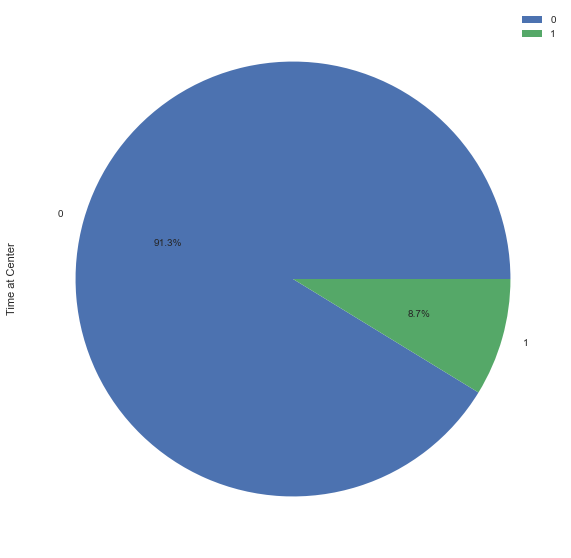

In [64]:
data['Time at Center'].value_counts(normalize=True).plot(kind='pie',legend=True,autopct='%1.1f%%',figsize=(10,10))

Around 1:10 ratio between minority and majority class

### Age distribution

We're going to take another look at the distribution of the age variable. Earlier on we noticed high standard deviation, much larger than the mean. This suggests this variable has extreme upper bound outliers

In [65]:
data['Age upon Intake Days'].describe()

count    95379.000000
mean       704.179830
std       1052.600642
min          0.000000
25%         30.000000
50%        365.000000
75%        730.000000
max       9125.000000
Name: Age upon Intake Days, dtype: float64

In [66]:
data['Age upon Intake Days'].skew()

2.414008446471474

In [67]:
data['Age upon Intake Days'].kurtosis()

6.231701370120961

Text(0.5, 0, 'Age (Days)')

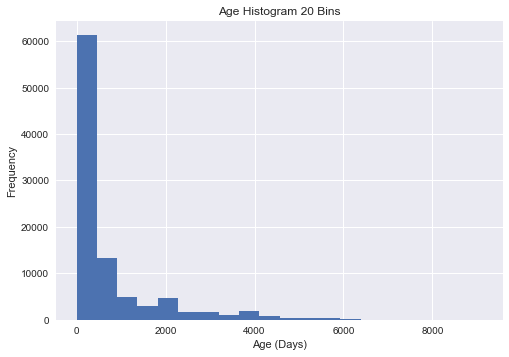

In [68]:
ax = data['Age upon Intake Days'].plot(kind='hist',bins=20,title='Age Histogram 20 Bins')
ax.set_xlabel("Age (Days)")


Text(0, 0.5, 'Frequency')

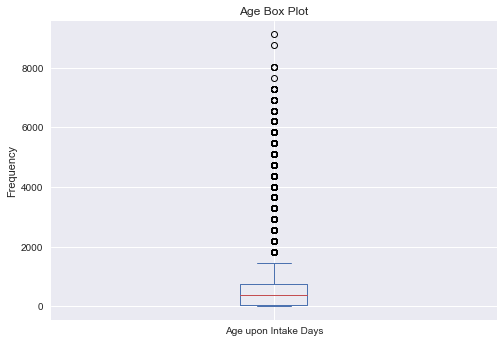

In [69]:
ax1 =data['Age upon Intake Days'].plot(kind='box',title='Age Box Plot')
ax1.set_ylabel('Frequency')

In [70]:
data.loc[data['Age upon Intake Days']>2000].shape[0]

10003

<AxesSubplot:>

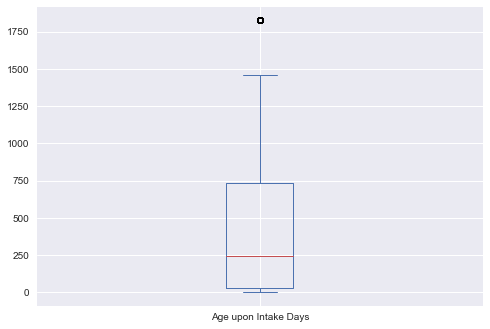

In [71]:
data.loc[data['Age upon Intake Days']<=2000]['Age upon Intake Days'].plot(kind='box')
# s

Based on skew, kurtosis and graphs we can tell this variable is extremely non-normal. Even after removing the top 10% of age range, the boxplot still looks extremely skewed.

We have several options.

1. Remove extremely high age values 
    - 10% of dataset is over 2000 days in age
    - 25% of dataset is under 30 days in age
    - Different species have different longevity
2. Bin into ordinal categorical variable
3. Transform variable with log or boxcox transform

We will not remove the high values- they can still be relevant.

We will check the transformation outcomes and if that looks promising, we will use that approach. Otherwise we will bin to categorical values.

In [72]:
data['Age_Shift1']=data['Age upon Intake Days']+1

<ipython-input-72-12dbdabff37c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_Shift1']=data['Age upon Intake Days']+1


In [73]:
len(boxcox(data['Age_Shift1']))

2

In [74]:
boxcox(data['Age_Shift1'])[0]

array([ 1.48801582,  4.01057616, 11.23726824, ...,  9.37060391,
        9.37060391,  9.37060391])

In [75]:
boxcox(data['Age_Shift1'])[1] #lambda value of .1, close to log transformation

0.10097846918570004

<ipython-input-76-de0db635f918>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AgeBoxCox']=boxcox(data['Age_Shift1'])[0]


Text(0.5, 0, 'BoxCox Transform of Age (λ=.1)')

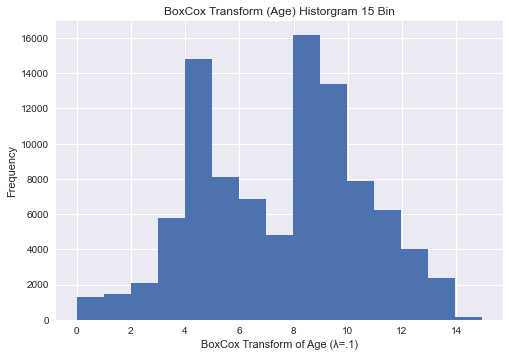

In [76]:
data['AgeBoxCox']=boxcox(data['Age_Shift1'])[0]
ax2 = data['AgeBoxCox'].plot(kind='hist',bins=15, title='BoxCox Transform (Age) Historgram 15 Bin')
ax2.set_xlabel('BoxCox Transform of Age (λ=.1)')

In [77]:
data.loc[(data.AgeBoxCox>=3)&(data.AgeBoxCox<6)]['Pet Type'].value_counts(normalize=True)

Cat      0.693252
Dog      0.285580
Other    0.019320
Bird     0.001848
Name: Pet Type, dtype: float64

In [78]:
data.loc[(data.AgeBoxCox>=3)&(data.AgeBoxCox<6)]['Time at Center'].value_counts()

0    23620
1     5055
Name: Time at Center, dtype: int64

In [79]:
5055/(23620+5055)

0.17628596338273758

In [80]:
data.loc[(data.AgeBoxCox<=11)&(data.AgeBoxCox>6)]['Pet Type'].value_counts(normalize=True)

Dog      0.608958
Cat      0.272761
Other    0.108876
Bird     0.009406
Name: Pet Type, dtype: float64

In [81]:
data.loc[(data.AgeBoxCox<=11)&(data.AgeBoxCox>6)]['Time at Center'].value_counts()

0    47571
1     1549
Name: Time at Center, dtype: int64

In [85]:
data.BaseBreed.value_counts()

domestic shorthair      32734
Other dog               21152
pit bull                 6174
Other terrier            3606
domestic medium hair     3392
german shepherd          3043
bat                      3027
domestic longhair        1542
dachshund                1416
siamese                  1317
Other shepherd           1196
Other Cat                1038
boxer                     933
miniature poodle          908
Other miniature           904
raccoon                   901
siberian husky            734
beagle                    695
great pyrenees            679
catahoula                 644
Other                     617
shih tzu                  593
Other bull                575
Other chihuahua           566
pointer                   502
rottweiler                492
Other hound               491
Other retriever           410
rabbit sh                 406
plott hound               361
maltese                   350
guinea pig                335
Other Bird                325
Other dach

In [86]:
data['BaseBreed']=data['BaseBreed'].replace(to_replace={'fox':'Other','opossum':'Other','chicken':'Other','skunk':'Other','squirrel':'Other','Other german':'Other dog','Other pit':'Other dog','Other spaniel':'Other dog'})

<ipython-input-86-40a8e6396ee5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BaseBreed']=data['BaseBreed'].replace(to_replace={'fox':'Other','opossum':'Other','chicken':'Other','skunk':'Other','squirrel':'Other','Other german':'Other dog','Other pit':'Other dog','Other spaniel':'Other dog'})


Big difference in time spent at center vs. age just based on this investigation.

We will leave the age variable as is for now and revisit changing it as a feature later.

In [93]:
cat_var = ['Outcome Type', 'Intake Type', 'Intake Condition',
       'Pet Type', 'MixBreed','BaseBreed', 'MixColor', 'BaseColor', 'NS_intake', 'NS_clinic',
       'City', 'Gender', 'FirstLetterName', 'NameLengthBin',]
min_class = data.loc[data['Time at Center']==1]
maj_class = data.loc[data['Time at Center']!=1]
cat={}
for i in cat_var:
    min_unq=min_class[i].unique()
    maj_unq=maj_class[i].unique()
    cat[i]= [i for i in maj_unq if i not in min_unq]
    print(i)
    print(cat[i])

Outcome Type
[]
Intake Type
[]
Intake Condition
[]
Pet Type
[]
MixBreed
[]
BaseBreed
[]
MixColor
[]
BaseColor
[]
NS_intake
[]
NS_clinic
[]
City
[]
Gender
[]
FirstLetterName
[]
NameLengthBin
[]


### Chi-squared test of independence

In [94]:
data['BaseBreed'].value_counts()

domestic shorthair      32734
Other dog               21214
pit bull                 6174
Other terrier            3606
domestic medium hair     3392
german shepherd          3043
bat                      3027
Other                    1579
domestic longhair        1542
dachshund                1416
siamese                  1317
Other shepherd           1196
Other Cat                1038
boxer                     933
miniature poodle          908
Other miniature           904
raccoon                   901
siberian husky            734
beagle                    695
great pyrenees            679
catahoula                 644
shih tzu                  593
Other bull                575
Other chihuahua           566
pointer                   502
rottweiler                492
Other hound               491
Other retriever           410
rabbit sh                 406
plott hound               361
maltese                   350
guinea pig                335
Other Bird                325
Other dach

In [99]:
cat_var = ['Outcome Type', 'Intake Type', 'Intake Condition',
       'Pet Type', 'MixBreed','BaseBreed', 'MixColor', 'BaseColor', 'NS_intake', 'NS_clinic',
       'City', 'Gender', 'FirstLetterName', 'NameLengthBin',]
min_class = data.loc[data['Time at Center']==1]
maj_class = data.loc[data['Time at Center']!=1]
for i in cat_var:
    min_class_dict = min_class[i].value_counts()
    min_dict=[x for i,x in sorted(min_class_dict.items(),key=lambda item:item[0])]
    maj_class_dict = maj_class[i].value_counts(normalize=True)*min_class.shape[0]
    maj_dict=[x for i,x in sorted(maj_class_dict.items(),key=lambda item:item[0])]
    print(f'Variable :{i}    |   {chisquare(min_dict,maj_dict)}')

Variable :Outcome Type    |   Power_divergenceResult(statistic=7610.019442688509, pvalue=0.0)
Variable :Intake Type    |   Power_divergenceResult(statistic=853.9550093189995, pvalue=2.4520082757766102e-182)
Variable :Intake Condition    |   Power_divergenceResult(statistic=662.5832953416442, pvalue=6.032674977340308e-141)
Variable :Pet Type    |   Power_divergenceResult(statistic=3347.296350521095, pvalue=0.0)
Variable :MixBreed    |   Power_divergenceResult(statistic=6.9748818743787435, pvalue=0.00826616789735318)
Variable :BaseBreed    |   Power_divergenceResult(statistic=3439.266649848167, pvalue=0.0)
Variable :MixColor    |   Power_divergenceResult(statistic=156.01273894382774, pvalue=8.411699739172971e-36)
Variable :BaseColor    |   Power_divergenceResult(statistic=1133.2253640401755, pvalue=4.1374334835422404e-224)
Variable :NS_intake    |   Power_divergenceResult(statistic=548.4988224834383, pvalue=2.6702875666213084e-121)
Variable :NS_clinic    |   Power_divergenceResult(statis

City and MixBreed had highest pvalues.

In [111]:
list(min_class.NS_intake.value_counts())[-1]

932

In [147]:
#most frequent bin
#% of most frequent bin
#Number of bins
#smallest bin
#small bin % frequency
col = ['Column']
data_in=[]
for i in cat_var:
    for count,df in enumerate([data,min_class,maj_class]):
        if count==0:
            pref = 'All'
        elif count==1:
            pref = 'Min'
        elif count==2:
            pref='Maj'
        row = [i,pref]
        val_counts = df[i].value_counts(normalize=True)
        mfb=val_counts.index[0]
        pmfb=val_counts[0]
        row.append(mfb)
        row.append(round(pmfb*100,1))
        row.append(len(val_counts))
        row.append(val_counts.index[-1])
        row.append(round(list(val_counts)[-1]*100,1))
        data_in.append(row)
col.append('Class')
col.append('Mode')
col.append('Mode%')
col.append('BinNumber')
col.append('Min')
col.append('Min%')
cat_summ = pd.DataFrame(data=data_in,columns=col)
cat_summ

,Column,Class,Mode,Mode%,BinNumber,Min,Min%
0,Outcome Type,All,Adoption,41.7,5,Other Outcome,2.1
1,Outcome Type,Min,Adoption,83.8,5,Euthanasia,1.1
2,Outcome Type,Maj,Adoption,37.6,5,Other Outcome,2.2
3,Intake Type,All,Stray,73.5,6,Abandoned,0.1
4,Intake Type,Min,Stray,85.1,6,Euthanasia Request,0.0
5,Intake Type,Maj,Stray,72.4,6,Abandoned,0.1
6,Intake Condition,All,Normal,85.8,6,Other,0.4
7,Intake Condition,Min,Normal,85.1,6,Aged,0.1
8,Intake Condition,Maj,Normal,85.8,6,Other,0.4
9,Pet Type,All,Dog,51.0,4,Bird,0.6


In [126]:
all_df = data['Outcome Type'].value_counts().to_frame()
all_df

,Outcome Type
Adoption,39734
Transfer,32299
Return to Owner,13719
Euthanasia,7630
Other Outcome,1997


In [130]:
from ipywidgets import interact
@interact(cat =['Outcome Type', 'Intake Type', 'Intake Condition',
       'Pet Type', 'MixBreed','BaseBreed', 'MixColor', 'BaseColor', 'NS_intake', 'NS_clinic',
       'City', 'Gender', 'FirstLetterName', 'NameLengthBin',])
def show_freq(cat):
    plt.figure(figsize=(12, 8), dpi=80)
    all_df = pd.DataFrame()
    for count,df in enumerate([data,min_class,maj_class]):
        if count==0:
            pref = 'All'
        elif count==1:
            pref = 'Min'
        elif count==2:
            pref='Maj'
        ndf = df[cat].value_counts(normalize=True).to_frame()
        ndf.rename(columns={cat:'Count'},inplace=True)
        ndf['Class']=pref
        all_df=all_df.append(ndf)
    all_df[cat]=all_df.index
    ax = sns.barplot(x=cat, y="Count", hue="Class", data=all_df)
    plt.show()

interactive(children=(Dropdown(description='cat', options=('Outcome Type', 'Intake Type', 'Intake Condition', …

In [143]:
data=data[['Pet ID', 'Outcome Type', 'Intake Type', 'Intake Condition',
       'Pet Type',  'Time at Center', 'MixBreed',
       'BaseBreed', 'MixColor', 'BaseColor', 'NS_intake', 'NS_clinic',
       'City', 'Gender', 'FirstLetterName', 'NameLengthBin', 'Age_Shift1']]

In [144]:
data.to_csv(r'..\data\feature_final.csv',index=False)

# END

[*Back to top*](#top)